# Hands-on: EDA

This hands-on will cover some techniques for exploratory data analysis using the Citibike Trip Histories dataset. The first few sections include code to prepare the data.

In [2]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data - CitiBike Trip Histories

CitiBike provides the data of the bike share through this website: https://www.citibikenyc.com/system-data

For this exercise, we'll be using their trip history data which may be found [here](https://s3.amazonaws.com/tripdata/index.html). 

Kindly choose a 2021 month file to download (not the ones with JC as the prefix). You can download data for January or Febuary (20-50MB in file size for slow internet connections) and extract it to your data folder.

In [3]:
data = pd.read_csv(os.getenv('DSDATA') + '/202102-citibike-tripdata.csv')
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,304,2021-02-01 00:04:23.0780,2021-02-01 00:09:27.7920,3175,W 70 St & Amsterdam Ave,40.777480,-73.982886,4045,West End Ave & W 60 St,40.772370,-73.990050,27451,Subscriber,1996,2
1,370,2021-02-01 00:07:08.8080,2021-02-01 00:13:19.4670,3154,E 77 St & 3 Ave,40.773142,-73.958562,3725,2 Ave & E 72 St,40.768762,-73.958408,35000,Subscriber,1991,1
2,635,2021-02-01 00:07:55.9390,2021-02-01 00:18:31.0390,502,Henry St & Grand St,40.714211,-73.981095,411,E 6 St & Avenue D,40.722281,-73.976687,49319,Subscriber,1980,2
3,758,2021-02-01 00:08:42.0960,2021-02-01 00:21:20.7820,3136,5 Ave & E 63 St,40.766368,-73.971518,3284,E 88 St & Park Ave,40.781411,-73.955959,48091,Customer,1969,0
4,522,2021-02-01 00:09:32.6820,2021-02-01 00:18:15.4100,505,6 Ave & W 33 St,40.749013,-73.988484,3687,E 33 St & 1 Ave,40.743227,-73.974498,48596,Subscriber,1988,1


## Feature Extraction

In [4]:
data['starttime'] = pd.to_datetime(data['starttime'])
data['stoptime'] = pd.to_datetime(data['stoptime'])

data['dayofweek'] = data['starttime'].dt.dayofweek
data['hourofday'] = data['starttime'].dt.hour
data['year'] = data['starttime'].dt.year

## Feature Transformation

In [5]:
data['duration_min'] = data['tripduration']/60

## Feature Generation

In [6]:
data['age'] = data['starttime'].dt.year - data['birth year']
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,dayofweek,hourofday,year,duration_min,age
0,304,2021-02-01 00:04:23.078,2021-02-01 00:09:27.792,3175,W 70 St & Amsterdam Ave,40.777480,-73.982886,4045,West End Ave & W 60 St,40.772370,-73.990050,27451,Subscriber,1996,2,0,0,2021,5.066667,25
1,370,2021-02-01 00:07:08.808,2021-02-01 00:13:19.467,3154,E 77 St & 3 Ave,40.773142,-73.958562,3725,2 Ave & E 72 St,40.768762,-73.958408,35000,Subscriber,1991,1,0,0,2021,6.166667,30
2,635,2021-02-01 00:07:55.939,2021-02-01 00:18:31.039,502,Henry St & Grand St,40.714211,-73.981095,411,E 6 St & Avenue D,40.722281,-73.976687,49319,Subscriber,1980,2,0,0,2021,10.583333,41
3,758,2021-02-01 00:08:42.096,2021-02-01 00:21:20.782,3136,5 Ave & E 63 St,40.766368,-73.971518,3284,E 88 St & Park Ave,40.781411,-73.955959,48091,Customer,1969,0,0,0,2021,12.633333,52
4,522,2021-02-01 00:09:32.682,2021-02-01 00:18:15.410,505,6 Ave & W 33 St,40.749013,-73.988484,3687,E 33 St & 1 Ave,40.743227,-73.974498,48596,Subscriber,1988,1,0,0,2021,8.700000,33


#### Distance

Another feature we can generate from the data is distance. Although the provided values are in longitude and latitudes and they're measured in degrees, the distance calculated from these points would also be in degrees (and not meters). 

There's actually a library that specifically handles geospatial data called `geopy` ([Link](https://geopy.readthedocs.io/en/stable/#module-geopy.distance)). For simplicity sake in this tutorial, we use an existing function that calculates the geodesic distance using the Haversine formula given the starting and ending longitude and latitudes: `calculate_distance(lat1, lon1, lat2, lon2)`

Credits to [Wayne Dyck](https://gist.github.com/rochacbruno/2883505) for the function.

In [7]:
def calculate_distance(lat1, lon1, lat2, lon2):
    """
    Calculates the distance provided a pair of longitudes and latitudes
    using the Haversine formula
    
    Returns the distance in kilometers.
    """
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [8]:
data['distance_km'] = data.apply(lambda x: calculate_distance(x['start station latitude'], x['start station longitude'],
                                        x['end station latitude'], x['end station longitude']), axis=1)

----
----

# Exploratory Data Analysis

We will do the following:
1. Examine the size and structure of the data
2. Examine each field individually
3. Examine relationships/correlations
4. Identify anomalies/outliers

## 1. Size and structure of the data

In [9]:
data.shape

(634631, 21)

After feater transformations, the dataset now has 634,631 observations with 21 variables.

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634631 entries, 0 to 634630
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   tripduration             634631 non-null  int64         
 1   starttime                634631 non-null  datetime64[ns]
 2   stoptime                 634631 non-null  datetime64[ns]
 3   start station id         634631 non-null  int64         
 4   start station name       634631 non-null  object        
 5   start station latitude   634631 non-null  float64       
 6   start station longitude  634631 non-null  float64       
 7   end station id           634631 non-null  int64         
 8   end station name         634631 non-null  object        
 9   end station latitude     634631 non-null  float64       
 10  end station longitude    634631 non-null  float64       
 11  bikeid                   634631 non-null  int64         
 12  usertype        

The dataset has a variety of datatypes: integer and float values, date and time, and strings. There are no variables with null/missing values.

In [11]:
# Get descriptive statistics of quantitative variables
data.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender,dayofweek,hourofday,year,duration_min,age,distance_km
count,6.346310e+05,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.0,634631.000000,634631.000000,634631.000000
mean,1.044040e+03,2113.291434,40.741955,-73.976605,2113.355662,40.741686,-73.976779,41295.079259,1971.745553,0.342484,3.147275,14.011964,2021.0,17.400660,49.254447,1.840111
std,1.206238e+04,1576.082952,0.034753,0.022764,1576.501895,0.034642,0.022868,7149.176733,8.307802,0.608901,1.865895,4.586800,0.0,201.039591,8.307802,1.562775
min,6.100000e+01,72.000000,40.644512,-74.023087,72.000000,40.644512,-74.043991,14534.000000,1885.000000,0.000000,0.000000,0.000000,2021.0,1.016667,17.000000,0.000000
25%,3.450000e+02,438.000000,40.718822,-73.992573,437.000000,40.718822,-73.993012,36480.000000,1969.000000,0.000000,2.000000,11.000000,2021.0,5.750000,52.000000,0.786475
50%,5.930000e+02,3115.000000,40.741740,-73.981540,3115.000000,40.741459,-73.981687,42766.000000,1969.000000,0.000000,3.000000,15.000000,2021.0,9.883333,52.000000,1.396765
75%,1.036000e+03,3538.000000,40.764719,-73.961255,3537.000000,40.763954,-73.961199,47762.000000,1969.000000,1.000000,5.000000,17.000000,2021.0,17.266667,52.000000,2.411052
max,2.065242e+06,4419.000000,40.852252,-73.884308,4419.000000,40.852252,-73.884308,50133.000000,2004.000000,2.000000,6.000000,23.000000,2021.0,34420.700000,136.000000,17.937935


Although these variables are all quantitative, it doesn't really make sense to look at the statistics for unique IDs and spatial data like `start station id`, `start station latitude`, `start station longitude`, and `bikeid`, among others. Here, we will just focus on the values for `birth year`, `duration_min`, `age`, and `distance_km`.

Few insights from the `data.describe()` function:

1. The minimum `birth year` is 1885 which has a remarkably large difference from the 25th percentile value. Can this be anomalous data?
2. There is a very large difference between the maximum and 75th percentile values of `duration_min` and `age`.
3. Observations #1 & #2 indicate possible outliers in the data. 

In [12]:
data.describe(include=np.object)

,start station name,end station name,usertype
count,634631,634631,634631
unique,1274,1283,2
top,1 Ave & E 68 St,1 Ave & E 68 St,Customer
freq,4251,4226,468459


These are the descriptive stats for the categorical variables. 

## 2. Examining individual variables

Now, we can start generating simple visualizations to help us better understand the values in each variable.

### User type

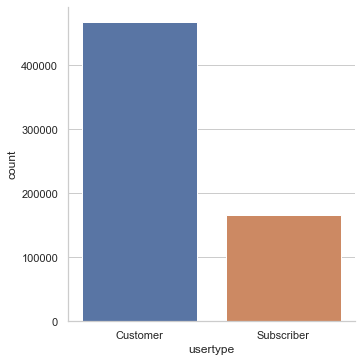

In [13]:
sns.set_theme(style="whitegrid")

usertype_plot = sns.catplot(x="usertype", kind="count", order=["Customer", "Subscriber"], data=data)

There are more one-time users of CitiBike than there are subscribers.

### Age

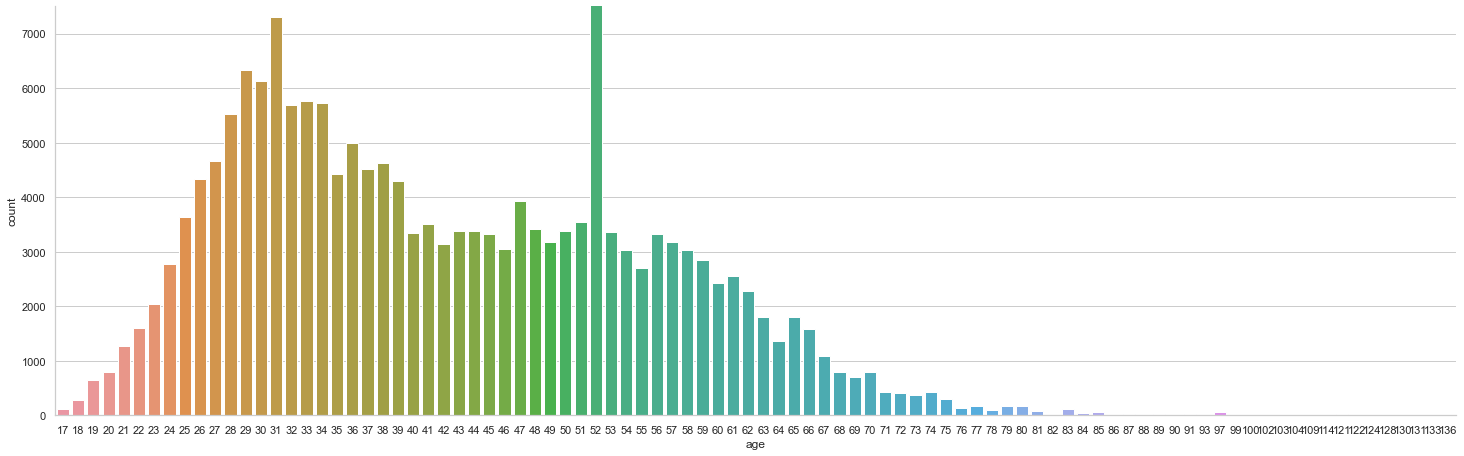

In [14]:
age_plot = sns.catplot(x="age", kind="count", data=data)
age_plot.set(ylim=(0,7500)) # Limit the maximum y-axis value because of one outlier count for age 52
age_plot.fig.set_size_inches(25, 6.5)

In [15]:
data["age"].value_counts()

52     464712
31       7312
29       6327
30       6135
33       5758
        ...  
103         2
130         2
93          2
88          2
136         1
Name: age, Length: 92, dtype: int64

### Starting Stations

In [16]:
start_stations = data["start station name"].value_counts().rename_axis('Station name').reset_index(name='counts')
start_stations = start_stations.nlargest(10, 'counts')
start_stations

,Station name,counts
0,1 Ave & E 68 St,4251
1,W 21 St & 6 Ave,3762
2,E 17 St & Broadway,3230
3,W 33 St & 7 Ave,3213
4,E 13 St & Avenue A,3044
5,E 33 St & 1 Ave,2970
6,Broadway & W 60 St,2757
7,Grand St & Elizabeth St,2700
8,Clinton St & Grand St,2620
9,Pershing Square North,2606


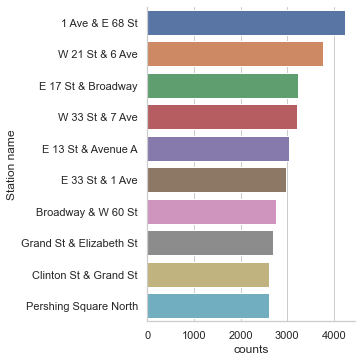

In [17]:
start_station_plot = sns.catplot(y="Station name", x="counts", orient="h", kind="bar", data=start_stations)

### Ending stations

In [18]:
end_stations = data["end station name"].value_counts().rename_axis('Station name').reset_index(name='counts')
end_stations = end_stations.nlargest(10, 'counts')
end_stations

,Station name,counts
0,1 Ave & E 68 St,4226
1,W 21 St & 6 Ave,3734
2,E 17 St & Broadway,3481
3,W 33 St & 7 Ave,3161
4,E 13 St & Avenue A,3043
5,E 33 St & 1 Ave,3004
6,Broadway & W 60 St,2789
7,Grand St & Elizabeth St,2723
8,Pershing Square North,2622
9,Clinton St & Grand St,2611


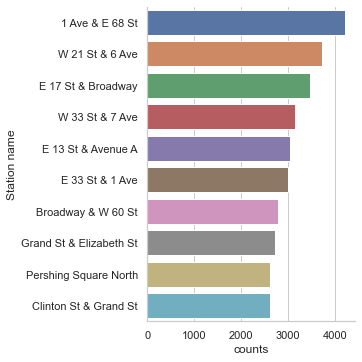

In [19]:
end_station_plot = sns.catplot(y="Station name", x="counts", orient="h", kind="bar", data=end_stations)

We can see from both plots that the top 10 start and end stations are consistent with each other. This indicates high taffic areas which can be potential locations for adding more bikes and bike docks. 

### Origin-Destination Pairs

Here we create `od_trips` which contains the origin-destination pairs derived from the unique pairs of `start station name` and `end station name`.

In [20]:
## Count of rides per OD
od_trips = data.groupby(['start station name', 'end station name'], as_index=False)['bikeid'].count()
od_trips = od_trips.rename(columns={"start station name": "start", "end station name": "end", "bikeid": "total_trips"}, errors="raise")
od_trips.head()

,start,end,total_trips
0,1 Ave & E 110 St,1 Ave & E 110 St,17
1,1 Ave & E 110 St,1 Ave & E 68 St,11
2,1 Ave & E 110 St,1 Ave & E 78 St,1
3,1 Ave & E 110 St,1 Ave & E 94 St,2
4,1 Ave & E 110 St,2 Ave & E 104 St,2


In [21]:
od_trips["od"] = od_trips["start"] + " to " + od_trips["end"]
od_trips

,start,end,total_trips,od
0,1 Ave & E 110 St,1 Ave & E 110 St,17,1 Ave & E 110 St to 1 Ave & E 110 St
1,1 Ave & E 110 St,1 Ave & E 68 St,11,1 Ave & E 110 St to 1 Ave & E 68 St
2,1 Ave & E 110 St,1 Ave & E 78 St,1,1 Ave & E 110 St to 1 Ave & E 78 St
3,1 Ave & E 110 St,1 Ave & E 94 St,2,1 Ave & E 110 St to 1 Ave & E 94 St
4,1 Ave & E 110 St,2 Ave & E 104 St,2,1 Ave & E 110 St to 2 Ave & E 104 St
...,...,...,...,...
164369,Wythe Ave & Metropolitan Ave,Willoughby Ave & Tompkins Ave,2,Wythe Ave & Metropolitan Ave to Willoughby Ave...
164370,Wythe Ave & Metropolitan Ave,Willoughby Ave & Walworth St,1,Wythe Ave & Metropolitan Ave to Willoughby Ave...
164371,Wythe Ave & Metropolitan Ave,Willoughby St & Fleet St,1,Wythe Ave & Metropolitan Ave to Willoughby St ...
164372,Wythe Ave & Metropolitan Ave,Wyckoff Av & Stanhope St,1,Wythe Ave & Metropolitan Ave to Wyckoff Av & S...


/Users/brianesamson/.pyenv/versions/3.7.6/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)


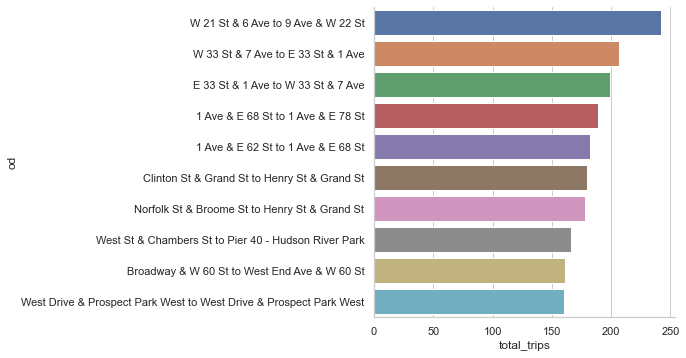

In [22]:
od_rank_plot = sns.catplot(y="od", x="total_trips", orient="h", kind="bar", data=od_trips.nlargest(10, "total_trips"))

### Origin-Destination Matrix

In this part, we focus on analyzing the number of trips between the top 10 `start` and `end` stations. It would be impossible to visually analyze for all possible pairs because the dataset is too big.

In [23]:
# Get the trips between the top 10 stations.

od_topten = od_trips[od_trips.start.isin(start_stations["Station name"]) & od_trips.end.isin(end_stations["Station name"])]
od_topten

,start,end,total_trips,od
2318,1 Ave & E 68 St,1 Ave & E 68 St,87,1 Ave & E 68 St to 1 Ave & E 68 St
2433,1 Ave & E 68 St,Broadway & W 60 St,37,1 Ave & E 68 St to Broadway & W 60 St
2451,1 Ave & E 68 St,Clinton St & Grand St,2,1 Ave & E 68 St to Clinton St & Grand St
2482,1 Ave & E 68 St,E 13 St & Avenue A,8,1 Ave & E 68 St to E 13 St & Avenue A
2489,1 Ave & E 68 St,E 17 St & Broadway,9,1 Ave & E 68 St to E 17 St & Broadway
...,...,...,...,...
145506,W 33 St & 7 Ave,E 33 St & 1 Ave,207,W 33 St & 7 Ave to E 33 St & 1 Ave
145574,W 33 St & 7 Ave,Grand St & Elizabeth St,4,W 33 St & 7 Ave to Grand St & Elizabeth St
145621,W 33 St & 7 Ave,Pershing Square North,93,W 33 St & 7 Ave to Pershing Square North
145660,W 33 St & 7 Ave,W 21 St & 6 Ave,21,W 33 St & 7 Ave to W 21 St & 6 Ave


In [24]:
# Create a matrix

od_matrix = pd.pivot_table(od_topten, index='start', columns='end', values='total_trips', aggfunc=np.sum, fill_value=0)
od_matrix

end,1 Ave & E 68 St,Broadway & W 60 St,Clinton St & Grand St,E 13 St & Avenue A,E 17 St & Broadway,E 33 St & 1 Ave,Grand St & Elizabeth St,Pershing Square North,W 21 St & 6 Ave,W 33 St & 7 Ave
start,,,,,,,,,,
1 Ave & E 68 St,87,37,2,8,9,11,13,13,1,62
Broadway & W 60 St,35,89,1,0,6,1,1,9,2,6
Clinton St & Grand St,0,1,97,20,11,1,90,3,4,0
E 13 St & Avenue A,10,0,18,107,35,5,11,3,30,5
E 17 St & Broadway,4,3,9,46,81,22,8,20,78,13
E 33 St & 1 Ave,40,1,1,23,32,64,8,84,32,199
Grand St & Elizabeth St,1,0,96,15,15,8,70,0,16,0
Pershing Square North,31,9,3,8,20,108,0,27,11,84
W 21 St & 6 Ave,2,4,6,19,25,12,8,10,69,18


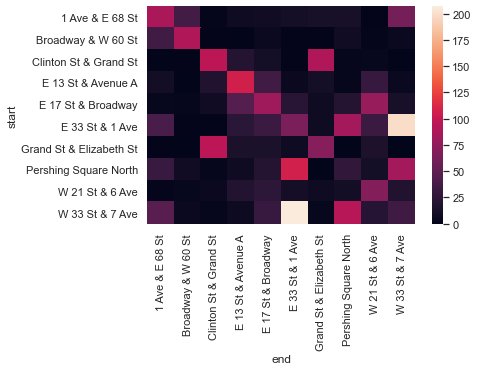

In [25]:
# Generate a heatmap

od_heatmap = sns.heatmap(od_matrix)

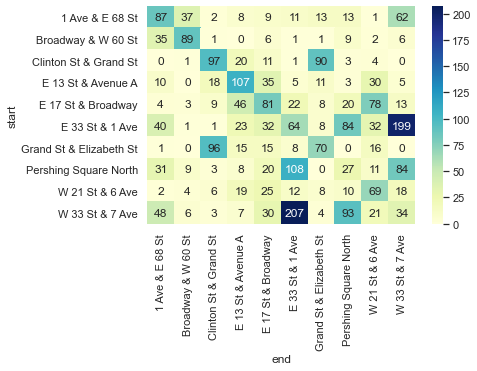

In [26]:
# Change color palette

od_heatmap = sns.heatmap(od_matrix, cmap="YlGnBu", annot=True, fmt="d")

### Gender

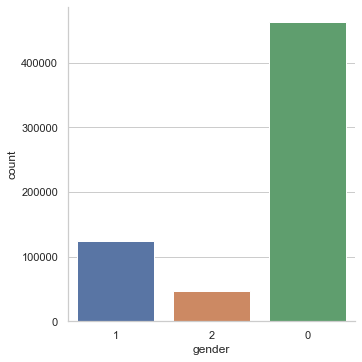

In [27]:
gender_plot = sns.catplot(x="gender", kind="count", order=[1, 2, 0], data=data)

It seems that the dataset contains mostly zero (0) values for the gender. We can continue our analysis by removing those trips with unknown gender.

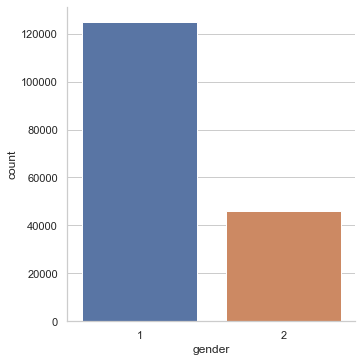

In [28]:
gender_plot = sns.catplot(x="gender", kind="count", order=[1, 2], data=data[data["gender"] > 0])

### Day of week

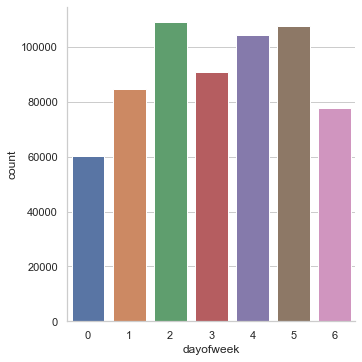

In [29]:
dow_plot = sns.catplot(x="dayofweek", kind="count", data=data)

The values for `dayofweek` starts with `0` or `Monday` and ends with `6` or `Sunday`. Based on the bar plot above, most trips happen on Wednesdays, Fridays and Saturdays.

### Hour of day

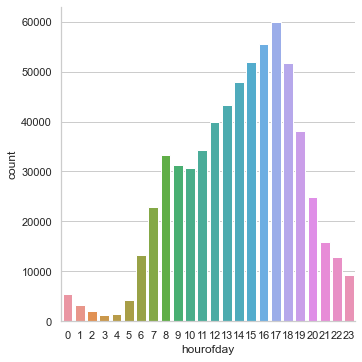

In [30]:
hod_plot = sns.catplot(x="hourofday", kind="count", data=data)

From the plot, the number of trips starts increasing from 12 noon and peaks at 5PM. 

### Duration in minutes

In [31]:
data["duration_min"].describe()

count    634631.000000
mean         17.400660
std         201.039591
min           1.016667
25%           5.750000
50%           9.883333
75%          17.266667
max       34420.700000
Name: duration_min, dtype: float64

### Detect and remove outliers

Outliers are defined as values that is more than 3 standard deviations away from the mean. Here, we detect them by computing the z score of each value, which is relative to the mean and standard deviation.

In [32]:
z_scores = zscore(data["duration_min"]) 

# Get their absolute values for easy filtering
abs_z_scores = np.abs(z_scores)

# An array of boolean values with same length as the original dataset. 
# True if value is less than 3 standard deviations from the mean or not an outlier. Otherwise, False.
filtered_entries = (abs_z_scores < 3) 

# Array of boolean values where value is True if it is an outlier, otherwise False.
duration_min_outliers = (abs_z_scores >= 3)
data[duration_min_outliers].duration_min # Show outlier values

55        3793.983333
128       4257.516667
280       1364.983333
287       3014.366667
290       3205.933333
             ...     
631214    7005.816667
632255    1363.300000
633024    5281.700000
633398    6875.366667
633877    1165.300000
Name: duration_min, Length: 624, dtype: float64

#### Histograms with KDE

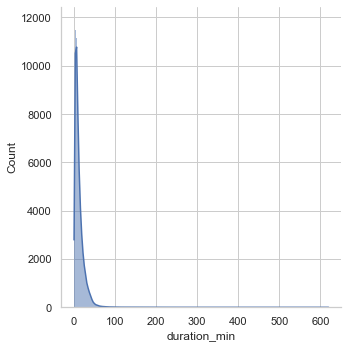

In [33]:
duration_plot = sns.displot(data=data[filtered_entries], x="duration_min", kde=True)

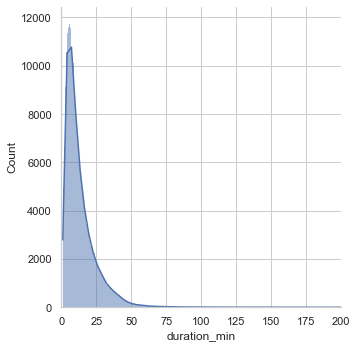

In [34]:
# Zoom in a little closer. Let's limit the x-axis to only show values up to 200

duration_plot = sns.displot(data=data[filtered_entries], x="duration_min", kde=True)
duration_plot.set(xlim=(0, 200))

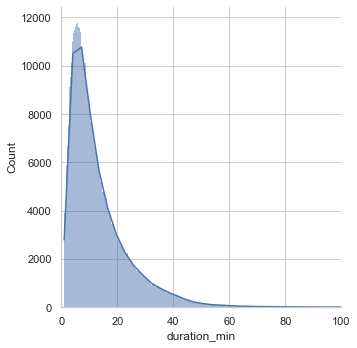

In [35]:
# Zoom in more. Let's limit the x-axis to only show values up to 100

duration_plot = sns.displot(data=data[filtered_entries], x="duration_min", kde=True)
duration_plot.set(xlim=(0, 100))

#### ECDF with Rug Plots

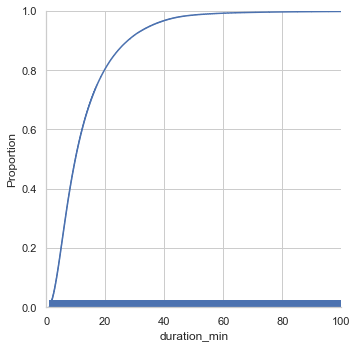

In [36]:
duration_plot = sns.displot(data=data[filtered_entries], x="duration_min", kind="ecdf", rug=True)
duration_plot.set(xlim=(0, 100))

## 3. Examine relationships/correlations

### User type and gender

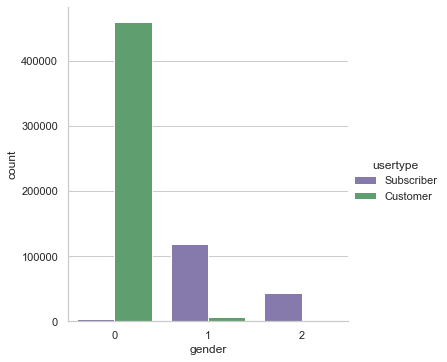

In [37]:
usertype_gender_plot = sns.catplot(x="gender", 
                                   kind="count", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   data=data)

- Users with 24-hour pass or 3-day passes did not have their gender information recorded.
- More male subscribers than females. 

### Trip distance, duration and user type

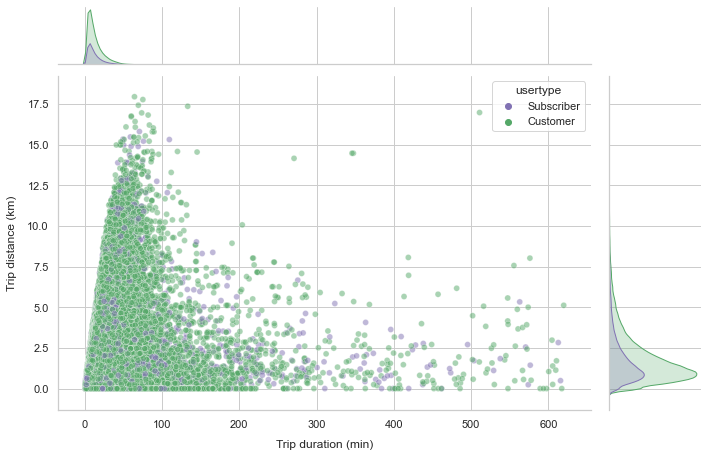

In [38]:
dur_dist_user_plot = sns.jointplot(data=data[filtered_entries], 
                                   x="duration_min", 
                                   y="distance_km", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   alpha=0.5)
dur_dist_user_plot.set_axis_labels("Trip duration (min)", "Trip distance (km)", labelpad=10)
dur_dist_user_plot.fig.set_size_inches(10.5, 6.5)

In [39]:
z_scores = zscore(data["distance_km"]) 

# Get their absolute values for easy filtering
abs_z_scores = np.abs(z_scores)

# An array of boolean values with same length as the original dataset. 
# True if value is less than 3 standard deviations from the mean or not an outlier. Otherwise, False.
filtered_dist = (abs_z_scores < 3) 

# Array of boolean values where value is True if it is an outlier, otherwise False.
dist_outliers = (abs_z_scores >= 3)
data[dist_outliers].distance_km # Show outlier values

72        7.559672
79        6.791290
107       7.055636
123       7.133794
287       6.816675
            ...   
634021    8.016243
634081    7.339160
634088    8.447268
634167    7.635918
634521    6.830051
Name: distance_km, Length: 11992, dtype: float64

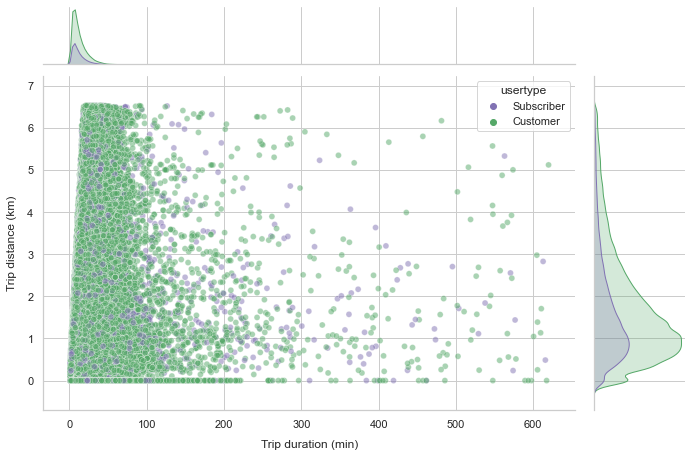

In [40]:
# Plot with outliers for both duration and distance
dur_dist_user_plot = sns.jointplot(data=data[filtered_entries & filtered_dist], 
                                   x="duration_min", 
                                   y="distance_km", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   alpha=0.5)
dur_dist_user_plot.set_axis_labels("Trip duration (min)", "Trip distance (km)", labelpad=10)
dur_dist_user_plot.fig.set_size_inches(10.5, 6.5)

### Get correlation between quantitative variables

In [41]:
data_to_corr = data[["gender", "duration_min", "age", "distance_km"]]
data_to_corr

,gender,duration_min,age,distance_km
0,2,5.066667,25,0.828754
1,1,6.166667,30,0.487242
2,2,10.583333,41,0.971186
3,0,12.633333,52,2.124707
4,1,8.700000,33,1.342431
...,...,...,...,...
634626,1,2.250000,33,0.233175
634627,0,5.966667,52,0.555965
634628,0,4.816667,52,0.925453
634629,1,2.766667,35,0.632157


In [42]:
z_scores = zscore(data_to_corr[["duration_min", "age", "distance_km"]]) 

# Get their absolute values for easy filtering
abs_z_scores = np.abs(z_scores)

# An array of boolean values with same length as the original dataset. 
# True if value is less than 3 standard deviations from the mean or not an outlier. Otherwise, False.
filtered_rows = (abs_z_scores < 3).all(axis=1) 

# Array of boolean values where value is True if it is an outlier, otherwise False.
data_to_corr_outliers = (abs_z_scores >= 3)
data_to_corr[data_to_corr_outliers] # Show outlier values

,gender,duration_min,age,distance_km
25,1,19.883333,21,0.000000
28,1,18.783333,23,1.313043
32,1,4.600000,23,0.835615
33,1,21.833333,22,1.009758
37,1,6.316667,21,0.872510
...,...,...,...,...
634413,1,3.650000,79,0.435061
634474,0,43.750000,21,0.814466
634478,1,23.783333,23,4.652121
634521,0,41.866667,52,6.830051


In [43]:
data_to_corr = data_to_corr[filtered_rows]

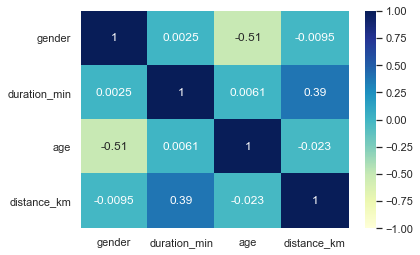

In [44]:
data_corr_heatmap = sns.heatmap(data_to_corr.corr(), 
                                center=0, 
                                cmap="YlGnBu", 
                                annot=True, 
                                vmin=-1, 
                                vmax=1)

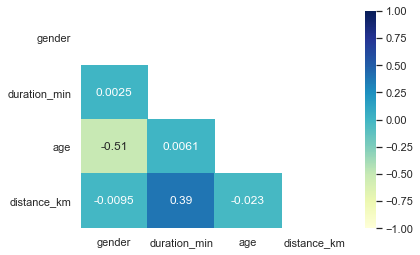

In [45]:
mask = np.triu(np.ones_like(data_to_corr.corr(), dtype=bool))

data_corr_heatmap = sns.heatmap(data_to_corr.corr(), 
                                center=0, 
                                cmap="YlGnBu", 
                                annot=True, 
                                mask=mask,
                                vmin=-1, 
                                vmax=1)

Variables `distance_km` and `duration_min` showed some positive correlation. We can still include them as features in a modeling task later.